# Deep Dive Tutorial: Feature Engineering

## Learning Objectives

In this tutorial you will learn:
1. How to create and use views
2. How features, entities, and observation sets are used together
3. How to filter views
4. How to join views
5. How to aggregate data into features
6. How to create features from features
7. How to add a feature to a view
8. How to use signal types for creative feature ideation
9. How entities are the key to coherent feature lists

## Set up the prerequisites

Learning Objectives

In this section you will:
* start your local featurebyte server
* import libraries
* learn about catalogs
* activate a pre-built catalog

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np

# load the featurebyte SDK
import featurebyte as fb
from featurebyte.api.request_column import RequestColumn

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

16:50:25 | INFO     | Using configuration file at: C:\Users\colin\.featurebyte\config.yaml
16:50:25 | INFO     | Active profile: local (http://127.0.0.1:8088)
16:50:25 | INFO     | SDK version: 0.2.2
16:50:25 | INFO     | Active catalog: default
16:50:25 | INFO     | 0 feature list, 0 feature deployed
16:50:25 | INFO     | (1/4) Starting featurebyte services
16:50:28 | INFO     | (2/4) Creating local spark feature store
16:50:28 | INFO     | (3/4) Import datasets
16:50:28 | INFO     | Dataset grocery already exists, skipping import
16:50:28 | INFO     | Dataset healthcare already exists, skipping import
16:50:28 | INFO     | Dataset creditcard already exists, skipping import
16:50:28 | INFO     | (4/4) Playground environment started successfully. Ready to go! 🚀


### Create a pre-built catalog for this tutorial, with the data, metadata, and features already set up

Note that creating a pre-built catalog is not a step you will do in real-life. This is a function specific to this quick-start tutorial to quickly skip over many of the preparatory steps and get you to a point where you can materialize features.

In a real-life project you would do data modeling, declaring the tables, entities, and the associated metadata. This would not be a frequent task, but forms the basis for best-practice feature engineering.

In [2]:
# get the functions to create a pre-built catalog
from prebuilt_catalogs import *

# create a new catalog for this tutorial
catalog = create_tutorial_catalog(PrebuiltCatalog.DeepDiveFeatureEngineeering)

Cleaning up existing tutorial catalogs


16:50:35 | INFO     | Catalog activated: deep dive feature engineering 20230516:1650


Building a deep dive catalog for feature engineering named [deep dive feature engineering 20230516:1650]
Creating new catalog
Catalog created
Registering the source tables
Registering the entities
Tagging the entities to columns in the data tables
Populating the feature store with example features
Catalog created and pre-populated with data and features


## Create Views of Tables within the Catalog

Learning Objectives

In this section you will learn:
* the dataset being used in this tutorial
* the purpose of FeatureByte tables
* standard table types
* how to load a table
* the purpose of FeatureByte views
* how to create a view from a table

### Introduction to the French grocery dataset

This tutorial uses the French grocery dataset that has been pre-installed in quick-start feature engineering catalog. It consists of 4 data tables recording grocery purchasing activity for each customer.<br>
1. <b>GroceryCustomer</b> is a slowly changing dimension table containing customer attributes.
2. <b>GroceryInvoice</b> is an event table containing grocery purchase transactions.
3. <b>InvoiceItems</b> is an event items table containing details of the basket of grocery items purchased in each transaction.
4. <b>GroceryProduct</b> is a dimension table containing the product attributes for each grocery item being sold.

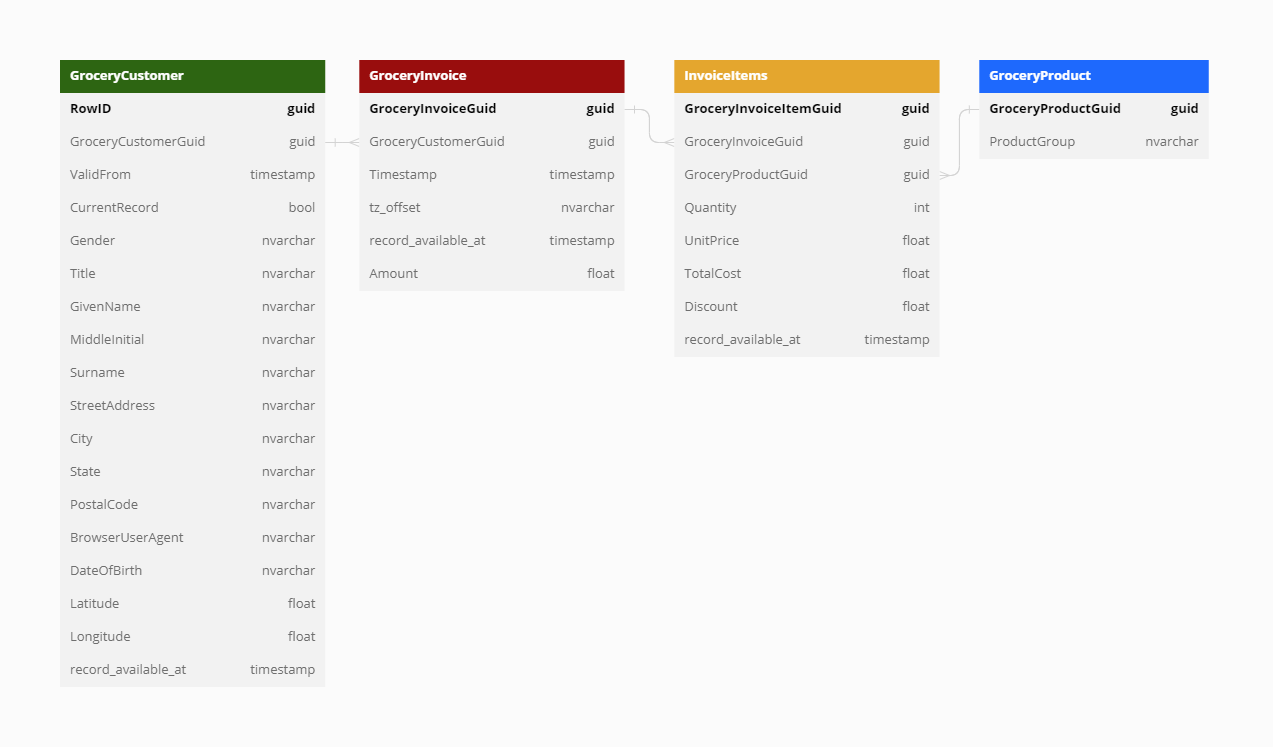

### Concept: Catalog table

A Catalog Table provides a centralized location for metadata about a source table. This metadata determines the type of operations that can be applied to the table's views and includes essential information for feature engineering.


### Concept: Table types

Understanding the type of data contained in a table is crucial because it helps determine the appropriate feature engineering techniques that can be applied to the table.

Featurebyte supports four of the most common types of data table.

1. An <b>event</b> table represents a table in the data warehouse where each row indicates a unique business event occurring at a particular time. Event tables can take various forms, such as an Order table in E-commerce, Credit Card Transactions in Banking, Doctor Visits in Healthcare, and Clickstream on the Internet.  
2. An <b>item</b> table represents a table in the data warehouse containing detailed information about a specific business event. For instance, an Item table can contain information about Product Items purchased in Customer Orders or Drug Prescriptions issued during Doctor Visits by Patients.
3. A <b>dimension</b> table represents a table in the data warehouse containing static descriptive data. Using a Dimension table requires special attention. If the data in the table changes slowly, it is not advisable to use it because these changes can cause significant data leaks during model training and adversely affect the inference performance. In such cases, it is recommended to use a Slowly Changing Dimension table of Type 2 that maintains a history of changes. For example, dimension data could contain the product group of each grocery product.
4. A <b>slowly changing dimension</b> (SCD) table represents a table in a data warehouse that contains data that changes slowly and unpredictably over time. There are two main types of SCDs: Type 1, which overwrites old data with new data, and Type 2, which maintains a history of changes by creating a new record for each change. FeatureByte only supports the use of Type 2 SCDs since SCDs of Type 1 may cause data leaks during model training and poor performance during inference. An SCD Table of Type 2 utilizes a natural key to distinguish each active row and facilitate tracking of changes over time. The SCD table employs effective and expiration date columns to determine the active status of a row. In certain instances, an active flag column may replace the expiration date column to indicate if a row is currently active. For example, slowly changing dimension data could contain customer data, which has attributes that need versioning, such as when a customer changes address.

### Example: Load featurebyte tables

FeatureByte works on the principle of not moving data unnecessarily. So when you load a featurebyte table, you load its metadata, not the full contents of the table.

In [3]:
# get the tables for this workspace
grocery_customer_table = catalog.get_table("GROCERYCUSTOMER")
grocery_items_table = catalog.get_table("INVOICEITEMS")
grocery_invoice_table = catalog.get_table("GROCERYINVOICE")
grocery_product_table = catalog.get_table("GROCERYPRODUCT")

### Concept: FeatureByte view

A FeatureByte view is a local virtual table that can be modified and joined to other views to prepare data before feature definition. A view does not contain any data of its own, but instead retrieves data from the underlying tables each time it is queried. It doesn't modify the data in those tables either. The view object works similar to a SQL view.

### Load the tables for this catalog

In [4]:
# create the views
grocery_customer_view = grocery_customer_table.get_view()
grocery_invoice_view = grocery_invoice_table.get_view()
grocery_items_view = grocery_items_table.get_view()
grocery_product_view = grocery_product_table.get_view()

## Features

Learning Objectives

In this section you will learn:
* about FeatureByte features
* the purpose of entities
* the purpose and usage of observation sets

### Concept: Feature

A Feature object contains the logical plan to compute a feature which is usually used as input data to train or predict Machine Learning models.

There are three ways to define the plan for Feature objects from views: either as a Lookup feature, as an Aggregate feature or as a Cross Aggregate feature.

Additionally, Feature objects can be created as transformations of one or more existing features.

### Concept: Entity

An Entity object contains metadata on a real-world object or concept represented or referenced by tables within your data warehouse.

Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases.

All features must relate to an entity (or entities) as their primary unit of analysis.

### Concept: Feature Primary Entity
The primary entity of a feature defines the level of analysis for that feature.

The primary entity is usually a single entity. However, in some instances, it may be a tuple of entities.

When a feature is a result of an aggregation grouped by multiple entities, the primary entity is a tuple of those entities. For instance, if a feature quantifies the interaction between a customer entity and a merchant entity in the past, such as the sum of transaction amounts grouped by customer and merchant in the past 4 weeks, the primary entity is the tuple of customer and merchant.

When a feature is derived from features with different primary entities, the primary entity is determined by the entity relationships. The lowest level entity in the hierarchy is selected as the primary entity. If the entities have no relationship, the primary entity becomes a tuple of those entities.

For example, if a feature compares the basket of a customer with the average basket of customers in the same city, the primary entity is the customer since the customer entity is a child of the customer city entity. However, if the feature is the distance between the customer location and the merchant location, the primary entity becomes the tuple of customer and merchant since these entities do not have any parent-child relationship.

### Example: List entities

Note that in this case study, all entities except French state are used for joining tables. 

All entities can be used as a unit of analysis for features. For example, the french state entity can be used for creating features that aggregate over the geography.

In [5]:
# list the entities in the dataset
catalog.list_entities()

,id,name,serving_names,created_at
0,646343e55ddec2e093fe8659,frenchstate,[FRENCHSTATE],2023-05-16 08:50:45.240
1,646343e55ddec2e093fe8658,groceryproduct,[GROCERYPRODUCTGUID],2023-05-16 08:50:45.172
2,646343e55ddec2e093fe8657,groceryinvoice,[GROCERYINVOICEGUID],2023-05-16 08:50:45.105
3,646343e45ddec2e093fe8656,grocerycustomer,[GROCERYCUSTOMERGUID],2023-05-16 08:50:45.035


### Concept: Observation set

An observation set combines entity key values and historical points-in-time, for which you wish to materialize feature values.

The observation set can be a Pandas DataFrame or an ObservationTable object representing an observation set in the feature store.

### Concept: Observation table

An ObservationTable object is a representation of an observation set in the feature store. Unlike a local Pandas DataFrame, the ObservationTable is part of the catalog and can be shared or reused.

ObservationTable objects can be created from a source table or from a view after subsampling.

### Example: Creating an observation table

Some use cases are about events, and require predictions to be triggered when a specified event occurs.

For a use case requiring predictions about a grocery customer whenever an invoice event occurs, your observation set may be sampled from historical invoices.

In [6]:
# create a large observation table from a view

# filter the view to exclude points in time that won't have data for historical windows
filter = (grocery_invoice_view["Timestamp"] >= pd.to_datetime("2022-04-01")) & (
    grocery_invoice_view["Timestamp"] < pd.to_datetime("2023-04-01")
)
observation_set_view = grocery_invoice_view[filter].copy()

# create a new observation table
observation_table = observation_set_view.create_observation_table(
    name="200 customers who were active between 01-Apr-2022 and 31-Mar-2023",
    sample_rows=200,
    columns=["Timestamp", "GroceryCustomerGuid"],
    columns_rename_mapping={
        "Timestamp": "POINT_IN_TIME",
        "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
    },
)

# if the observation table isn't too large, you can materialize it
display(observation_table.to_pandas())

Done! |████████████████████████████████████████| 100% in 9.1s (0.11%/s)         


,POINT_IN_TIME,GROCERYCUSTOMERGUID
0,2022-08-31 15:58:39,abdef773-ab72-43b6-8e77-050804c1c5fc
1,2022-09-07 16:02:39,abdef773-ab72-43b6-8e77-050804c1c5fc
2,2022-04-02 19:30:03,aae48cd3-7646-4df6-9700-3ef7f29ec80f
3,2022-08-23 17:54:26,aae48cd3-7646-4df6-9700-3ef7f29ec80f
4,2022-05-11 15:52:06,17da4b5e-02b9-4e9b-8839-5a5aa77b9bf5
...,...,...
195,2022-08-16 14:15:16,bbaff8e5-44ab-4f61-a4e6-405f274bf429
196,2022-04-06 08:11:45,3dff3cdc-3e64-4b6f-ab62-8165afca8c55
197,2022-04-15 19:37:08,7ba62f2e-d7b7-4bfb-8059-628fc5cf3f92
198,2022-10-26 20:49:01,e55e1ee2-7f4e-47a2-95f2-5c7a7ad5602c


In [7]:
# create a short pandas observation set useful for previewing features at customer entity level

# create a new observation table
observation_table_customers = observation_set_view.create_observation_table(
    name="5 customers who were active between 01-Apr-2022 and 31-Mar-2023",
    sample_rows=5,
    columns=["Timestamp", "GroceryCustomerGuid"],
    columns_rename_mapping={
        "Timestamp": "POINT_IN_TIME",
        "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
    },
)
observation_set = observation_table_customers.to_pandas()

display(observation_set)

Done! |████████████████████████████████████████| 100% in 9.1s (0.11%/s)         


,POINT_IN_TIME,GROCERYCUSTOMERGUID
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef


In [8]:
# create a short pandas observation set useful for previewing features at invoice entity level

# create a new observation table
observation_table_invoices = observation_set_view.create_observation_table(
    name="5 invoices with timestamps between 01-Apr-2022 and 31-Mar-2023",
    sample_rows=5,
    columns=["Timestamp", "GroceryInvoiceGuid"],
    columns_rename_mapping={
        "Timestamp": "POINT_IN_TIME",
        "GroceryInvoiceGuid": "GROCERYINVOICEGUID",
    },
)
observation_set_invoices = observation_table_invoices.to_pandas()

display(observation_set_invoices)

Done! |████████████████████████████████████████| 100% in 9.1s (0.11%/s)         


,POINT_IN_TIME,GROCERYINVOICEGUID
0,2022-10-27 11:04:22,6806fcb5-ab2c-439d-a35a-296f2a891a80
1,2022-05-16 10:22:49,ebe9fe2b-2457-470e-b27c-dd07a18186e8
2,2022-08-20 17:31:23,50dd32a2-97f6-4092-8afb-7b7d08430f8b
3,2022-05-12 13:41:39,92d8e1fb-d882-4104-a7e2-794208162c4e
4,2022-11-30 17:55:27,961ea607-9375-4a14-ad70-fc3a6353f963


## Filtering

Learning Objectives

In this section you will learn:
* how to filter a view
* how to transform data using conditions and filters

### Example: Filtering a view

The syntax for filtering a view is the same as pandas.

In [9]:
# create a filter for filtering rows to see only small purchases
filter = grocery_invoice_view["Amount"] < 10
filtered_invoice_view = grocery_invoice_view[filter]

display(filtered_invoice_view.sample())

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,tz_offset,Amount
0,a425afee-805d-443c-8fe7-91c76a19630b,9c23c4e8-f0e8-4aa4-83e9-3d3525461a8f,2022-09-05 10:33:13,+02:00,8.16
1,92766e8c-d6dc-4cdc-92ec-465c75d202ae,b21ae11c-83cf-4146-832e-1163413a3295,2022-07-04 14:21:13,+02:00,8.98
2,c1615f5f-f70d-4f52-ac7d-cc5ca8defa35,dfdd117d-e9fc-46c5-96ce-642bfad7f2b9,2022-02-07 17:16:39,+01:00,5.23
3,ba7eb0c9-522d-44a1-86f7-d658c92698bb,56b44a06-48c8-4ea7-8314-972a69ff99be,2022-05-15 15:38:50,+02:00,1.89
4,94c248c5-11cc-423f-987f-04c7ce3b5dec,b21ae11c-83cf-4146-832e-1163413a3295,2023-01-25 21:59:33,+01:00,8.29
5,597d6b7d-be61-4bad-939c-0be97443be4f,806ca360-27ce-49e2-bec4-c048aaf14ad5,2023-04-21 14:50:22,+02:00,9.06
6,cdda7c23-e17f-47eb-af9a-ecf500a5c7db,43f100f0-f804-4774-a8a5-dee3ad2f9ea5,2023-01-23 22:22:02,-04:00,2.58
7,0c135ebc-5133-4a9f-b8c7-dc95ba0095d6,f8d10416-e125-4dcf-a351-08653114cf0f,2023-04-03 14:22:12,+02:00,1.88
8,8c375705-2092-4582-a723-da270df3e730,3019bdbf-667c-4081-acb5-26cd2d559c5e,2022-03-17 03:16:31,+03:00,5.25
9,e524cd1c-2a0d-437c-9d49-8eb293e9541d,cd9d2656-375c-4b43-8f7c-5f89729fd5f4,2022-04-04 19:27:25,+02:00,2.00


### Example: Conditional transformations

The featurebyte way of doing if-then-else transformations is via conditions or filters.

In [10]:
# flag items as discounted, free, or undiscounted
discounted_filter = grocery_items_view["Discount"] > 0
free_filter = grocery_items_view["TotalCost"] == 0

grocery_items_view["DiscountCategory"] = "Undiscounted"
grocery_items_view.DiscountCategory[discounted_filter] = "Discounted"
grocery_items_view.DiscountCategory[free_filter] = "Free"

display(grocery_items_view[["TotalCost", "DiscountCategory"]].sample())

,GroceryInvoiceItemGuid,TotalCost,DiscountCategory
0,0c5181e3-9d9c-402d-902a-1649c3a26232,1.74,Discounted
1,5b853ed2-aea7-4fad-aaa5-bcadbef0eba8,2.50,Discounted
2,d2d7633e-3bdf-430d-920e-13825cad3e19,0.75,Undiscounted
3,7c4c38cc-7150-4bca-b2c1-0d4616d4809f,1.98,Undiscounted
4,cd0d8e88-e8fd-41d9-a4a4-8c9d4e05a1d8,1.29,Undiscounted
5,d010fe4e-266c-4c7a-93dc-e9382bf701e3,1.00,Discounted
6,8e662549-45a1-44d6-9303-ed57ec075ee5,8.99,Undiscounted
7,aee67dc0-b9cc-494c-983c-615bc7e6d407,2.50,Discounted
8,c44ca187-bfec-4d36-942d-12b53d21e6c9,1.19,Discounted
9,200d5fcc-cb83-4d25-a4d8-823dd6b85532,0.25,Undiscounted


## Joins

Learning Objectives

In this section you will learn:
* how views are joined
* the purpose of natural keys
* which view types can be joined
* how joins are frequently unnecessary

### Concept: Principles of featurebyte joins

In featurebyte:
* Joins operate on views
* Join criteria by common entities, and by event timestamps for joins of event views and slowly changing data
* Similarly to pandas, for the right-hand-side view, the join key must be its index (its natural key).
* Joins add columns to an existing view
* Joins never increase the number of rows in a view.
* By default, the number of rows do not change after a join. However, the number of rows may reduce if an inner join is selected.
* Only one-to-one and many-to-one relationships are supported. One-to-many and many-to-many relationships are not supported.
* Always start with the view that has the <b>many</b> side of the relationship, then join the view that has the <b>one</b> side of the relationship
* Similarly to a left join, rows with no match will contain missing values for the joined fields

### Concept: Natural key

A Natural Key is a generally accepted identifier used to identify real-world objects uniquely. In a Slowly Changing Dimension (SCD) table, a natural key (also called alternate key) is a column or a group of columns that remain constant over time and uniquely identifies each active row in the table at any point-in-time.

This key is crucial in maintaining and analyzing the historical changes made in the table.

### Concept: View joins

To join two views, use the `join()` method of the left view and specify the right view object in the `other_view` parameter. The method will match rows from both views based on a shared key, which is either the primary key of the right view or the natural key if the right view is an SCD view.

If the shared key identifies an entity that is referenced in the left view or the column name of the shared key is the same in both views, the `join()` method will automatically identify the column in the left view to use for the join.

By default, a left join is performed, and the resulting view will have the same number of rows as the left view. However, you can set the `how` parameter to 'inner' to perform an inner join. In this case, the resulting view will only contain rows where there is a match between the columns in both tables.

When the right view is an SCD view, the event timestamp of the left view determines which record of the right view to join.

### Example: Join event data to item data

Event data is automatically joined to item data via the event ID.

When an ItemView is created, the event_timestamp and the entities of the event data the item data is associated with are automatically added. Featurebyte automatically joins the parent event's entity and timestamp to the item view.

The preferred method to add columns from the event view is the join_event_data_attributes method.

In [11]:
# copy the invoice amount into the items view
grocery_items_view = grocery_items_view.join_event_table_attributes(
    ["Amount"], event_suffix="_invoice_total"
)

display(grocery_items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,tz_offset,DiscountCategory,Amount_invoice_total
0,c6c7c746-782c-418b-b123-7ded5a8d8d30,e87223dc-c5ef-4360-8637-86dc69af5d39,2d19bd87-a6ea-4553-9caa-1ab6d7e322b9,1.0,2.000,2.00,1.49,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84
1,a2c85c99-65a6-480b-9259-3339a3b5dc19,e87223dc-c5ef-4360-8637-86dc69af5d39,ed2445ad-8a97-4a4d-9f5c-eb253d66f916,1.0,0.990,0.99,0.20,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84
2,c8d0bba1-5adf-4747-b6f7-cd16925392dc,e87223dc-c5ef-4360-8637-86dc69af5d39,77b6847c-65bd-4e40-925f-7c2e2db80936,1.0,1.990,1.99,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84
3,adb793ab-90ff-4bc0-a9eb-47f71952d97c,e87223dc-c5ef-4360-8637-86dc69af5d39,7b3f3630-f2e4-4d18-8174-36d35d171069,1.0,2.000,2.00,1.15,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84
4,700d6299-9e33-4a10-8054-7cdcb9fa8529,e87223dc-c5ef-4360-8637-86dc69af5d39,8a01f8db-9796-4e17-8e8d-b893770e5a40,1.0,1.000,1.00,0.61,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84
5,fe0683c7-f8ae-4aa3-a1a8-6e762c262644,e87223dc-c5ef-4360-8637-86dc69af5d39,525dfef6-62a2-488d-9f2e-c4631cc4a8a2,1.0,1.290,1.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84
6,1b194981-b1bb-4306-a760-8131493f544f,e87223dc-c5ef-4360-8637-86dc69af5d39,c18c8a1c-bf87-4b2c-bc2b-8ea468e92d82,2.0,1.145,2.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84
7,c5f9cd59-4f4a-4a39-9d7a-7b7f0c2bb07f,e87223dc-c5ef-4360-8637-86dc69af5d39,9ee0d42e-dcb7-493b-98ed-ff63d951431d,1.0,1.290,1.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84
8,a6ac8ea1-fb10-4d11-9470-8b83d14e2f45,e87223dc-c5ef-4360-8637-86dc69af5d39,a99853f4-a90e-4b8b-97d0-d42aad75d1f0,1.0,1.290,1.29,0.50,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84
9,c35b60b8-941f-4fa6-b272-41c7bfca228c,e87223dc-c5ef-4360-8637-86dc69af5d39,49686449-3e3d-445f-b98b-26e86027855a,1.0,1.590,1.59,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84


### Example: Join Slowly Changing Dimension view to Event view

When the right view of a join is an SCD view, the event timestamp of the left view determines which record of the right view to join.

In [12]:
# Join selected columns from the grocery customer view with the grocery invoice view
grocery_invoice_view = grocery_invoice_view.join(
    grocery_customer_view[["Gender", "State"]], rsuffix="_Customer"
)

display(grocery_invoice_view.sample())

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,tz_offset,Amount,Gender_Customer,State_Customer
0,6a1bf1df-1878-489c-afa6-05c44b3505bb,32dd07d0-2c16-4b34-8cc9-01f258e0b935,2022-03-18 14:32:05,+01:00,2.98,male,Île-de-France
1,003cc207-03d8-4cc6-bcd0-fa00360b0c6e,59883bef-01fd-4321-95c4-fd0fad7f19ce,2022-06-30 17:34:23,+02:00,5.69,male,Rhône-Alpes
2,80c0a662-0978-4587-83e1-f23b2fdb54b1,cc4220ec-16ab-4bb9-991d-deef994bf27a,2022-05-15 14:34:42,+02:00,12.03,female,Île-de-France
3,22da6729-31d3-4865-9ca2-3df148d93138,144a0fe4-2137-43f6-b266-411b9eb7cb31,2022-01-18 19:00:11,+01:00,11.75,female,Île-de-France
4,f291eedf-e115-4546-9eed-d6fafbcdd80e,97074c73-4eea-4d6e-b4fb-09c975c570cc,2023-01-02 12:08:03,+01:00,2.50,male,Île-de-France
5,06eb0029-0091-4060-bc2f-dbfaa7581034,cc4220ec-16ab-4bb9-991d-deef994bf27a,2022-07-25 14:44:59,+02:00,6.99,female,Île-de-France
6,8cc7b598-54f5-4299-b0b5-e5488e701443,402d0c33-adfa-4bdd-a4be-fce76171466d,2022-05-25 07:52:05,+02:00,10.37,male,Alsace
7,a986b10e-12a0-4d96-888a-af69b00ab94b,6ef2203f-d91c-43f2-93c7-ffc414035765,2022-03-16 15:52:11,+01:00,9.47,male,Champagne-Ardenne
8,1f398f45-869d-4d33-9da6-0a1b4f10550a,a303679d-0e83-4e18-bc3f-6cae734ed8f3,2022-10-24 14:01:28,+02:00,111.42,male,Île-de-France
9,39e80f95-1f24-46d6-a604-f5cbb71a6c43,e490ab6d-c699-44c3-a284-41a7bbb1ee6f,2023-02-10 01:00:16,+01:00,1.29,female,Île-de-France


### Example: Join Dimension view to Item view

In [13]:
# join the grocery product view with the grocery items view
grocery_items_view = grocery_items_view.join(grocery_product_view)

display(grocery_items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,tz_offset,DiscountCategory,Amount_invoice_total,ProductGroup
0,c6c7c746-782c-418b-b123-7ded5a8d8d30,e87223dc-c5ef-4360-8637-86dc69af5d39,2d19bd87-a6ea-4553-9caa-1ab6d7e322b9,1.0,2.000,2.00,1.49,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84,Plats Cuisinés Surgelés
1,a2c85c99-65a6-480b-9259-3339a3b5dc19,e87223dc-c5ef-4360-8637-86dc69af5d39,ed2445ad-8a97-4a4d-9f5c-eb253d66f916,1.0,0.990,0.99,0.20,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84,"Pâtes, Riz, Purées et Féculents"
2,c8d0bba1-5adf-4747-b6f7-cd16925392dc,e87223dc-c5ef-4360-8637-86dc69af5d39,77b6847c-65bd-4e40-925f-7c2e2db80936,1.0,1.990,1.99,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84,Épices
3,adb793ab-90ff-4bc0-a9eb-47f71952d97c,e87223dc-c5ef-4360-8637-86dc69af5d39,7b3f3630-f2e4-4d18-8174-36d35d171069,1.0,2.000,2.00,1.15,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84,Premiers Soins
4,700d6299-9e33-4a10-8054-7cdcb9fa8529,e87223dc-c5ef-4360-8637-86dc69af5d39,8a01f8db-9796-4e17-8e8d-b893770e5a40,1.0,1.000,1.00,0.61,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84,Jus Frais
5,fe0683c7-f8ae-4aa3-a1a8-6e762c262644,e87223dc-c5ef-4360-8637-86dc69af5d39,525dfef6-62a2-488d-9f2e-c4631cc4a8a2,1.0,1.290,1.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84,Bonbons
6,1b194981-b1bb-4306-a760-8131493f544f,e87223dc-c5ef-4360-8637-86dc69af5d39,c18c8a1c-bf87-4b2c-bc2b-8ea468e92d82,2.0,1.145,2.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84,Chips et Tortillas
7,c5f9cd59-4f4a-4a39-9d7a-7b7f0c2bb07f,e87223dc-c5ef-4360-8637-86dc69af5d39,9ee0d42e-dcb7-493b-98ed-ff63d951431d,1.0,1.290,1.29,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84,Bonbons
8,a6ac8ea1-fb10-4d11-9470-8b83d14e2f45,e87223dc-c5ef-4360-8637-86dc69af5d39,a99853f4-a90e-4b8b-97d0-d42aad75d1f0,1.0,1.290,1.29,0.50,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Discounted,66.84,Pains
9,c35b60b8-941f-4fa6-b272-41c7bfca228c,e87223dc-c5ef-4360-8637-86dc69af5d39,49686449-3e3d-445f-b98b-26e86027855a,1.0,1.590,1.59,0.00,2022-01-01 18:01:00,caef12d6-ea0d-42ee-894a-77933ebf7f71,2022-01-01 17:39:59,+01:00,Undiscounted,66.84,Jus Frais


### Example: Use an inner join

Inner joins are useful for filtering views because they drop unmatched rows.

In [14]:
# get a grocery items view
soda_items_view = grocery_items_view.copy()

# create a filter to only include products that have the text "Soda" in the product group
filter = grocery_product_view.ProductGroup.str.contains("Soda")

# apply the filter to the grocery product view
soda_product_view = grocery_product_view[filter]

# join the grocery product view with the grocery items view
soda_items_view = soda_items_view.join(soda_product_view, how="inner", rsuffix="_Soda")

# preview the result
display(soda_items_view.preview())

,GroceryInvoiceItemGuid,GroceryInvoiceGuid,GroceryProductGuid,Quantity,UnitPrice,TotalCost,Discount,record_available_at,GroceryCustomerGuid,Timestamp,tz_offset,DiscountCategory,Amount_invoice_total,ProductGroup,ProductGroup_Soda
0,13876e34-1fa7-4099-9c1e-1acdb0f8cd6e,a7c15443-ec3a-412b-9b9b-2045d025f21c,2de4cc2b-ec73-44ac-ba71-8e504176ca95,2.0,0.59,1.18,0.00,2022-01-01 17:01:00,a91dcdc2-75a6-4172-94a0-ee53e715d634,2022-01-01 16:18:07,+01:00,Undiscounted,15.54,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
1,e510e8bc-7770-4ee1-848c-d933c0bcab91,a7c15443-ec3a-412b-9b9b-2045d025f21c,e60b8a87-5e36-4ad5-a21e-c345c0bbae90,1.0,0.59,0.59,0.00,2022-01-01 17:01:00,a91dcdc2-75a6-4172-94a0-ee53e715d634,2022-01-01 16:18:07,+01:00,Undiscounted,15.54,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
2,04e9a957-cfb0-4b5b-8787-c85862d1c4ec,ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123,38508242-2806-42d4-8276-a4b1b7676b87,1.0,1.59,1.59,0.00,2022-01-01 18:01:00,3bede04c-ff39-49b6-8f79-428c189dc1cc,2022-01-01 17:21:20,+01:00,Undiscounted,38.94,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
3,7566d89e-b619-493e-b2b3-6a37353336a4,ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123,ecccf560-0df9-4a45-898c-f5a3c9e27f6b,2.0,1.59,3.18,0.00,2022-01-01 18:01:00,3bede04c-ff39-49b6-8f79-428c189dc1cc,2022-01-01 17:21:20,+01:00,Undiscounted,38.94,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
4,e1b6f89c-75c9-452e-9b41-c469af489a04,ad9f2a45-bce4-4b9d-b6ec-f0b9bda76123,1cc8cfd0-a9f7-4e11-a6b0-7400681acbb3,2.0,1.59,3.18,0.00,2022-01-01 18:01:00,3bede04c-ff39-49b6-8f79-428c189dc1cc,2022-01-01 17:21:20,+01:00,Undiscounted,38.94,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
5,112a4dd3-9db3-4177-99ae-7da02e2e02b2,eed978c4-fe58-4498-ba0d-012ba7bc960d,a9949a9a-a3fe-4ca9-87cc-1c24e2ec7601,1.0,3.34,3.34,1.25,2022-01-01 12:01:00,8ad0c1f9-e6cb-43d2-a459-3297f1b29f55,2022-01-01 11:03:41,+01:00,Discounted,42.54,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
6,857f1cc6-c430-4f98-8002-abdadf65792b,94e5c784-5a12-4210-bb82-4026f329e278,6bfd3270-6467-41ab-a43d-1134e611f01e,1.0,1.29,1.29,0.00,2022-01-01 13:01:00,d0e9e8fa-bd2d-415f-a3b3-00c3e2f8e358,2022-01-01 12:40:29,+01:00,Undiscounted,1.29,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
7,8c53e8b2-9d64-43df-8abc-d13f25e4a297,6d8f8303-5cb1-41b5-ad73-3ca590c6f942,701d100a-f643-4f15-ae08-2b0b318ca34f,2.0,4.69,9.38,0.00,2022-01-01 16:01:00,05b77e7e-0a50-4341-b18c-be77efe3b084,2022-01-01 15:23:14,+01:00,Undiscounted,23.37,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
8,0e1b8ac1-5c0d-464e-b530-7e5e90d3f070,fdf02faa-3f00-4acd-97ec-76b177ae0bc0,ad65c776-5937-4bed-9a8f-cb5d0db3356b,1.0,1.39,1.39,0.00,2022-01-01 12:01:00,7846cb26-efa9-45a5-a1e1-6be13992ef59,2022-01-01 11:02:26,+01:00,Undiscounted,14.32,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"
9,b32ba058-2be5-482a-9439-30d097d970ec,13cc738b-c852-4348-a5cf-ffe6b860c281,5b9d37e5-4c91-4f40-8cfd-c0a0bb22fcbd,2.0,1.39,2.78,0.00,2022-01-01 18:01:00,7d1f7b4b-e121-47be-99ae-15264807b48a,2022-01-01 17:49:26,+01:00,Undiscounted,20.63,"Colas, Thés glacés et Sodas","Colas, Thés glacés et Sodas"


### Concept: Supported joins

Not all views can be joined to each other. SCD views cannot be joined to other SCD views, while only dimension views can be joined to other dimension views. Change views cannot be joined to any views.

The diagram below shows which view types can be joined to an existing view. Green indicates a join is possible. Grey indicates a join is not allowed.

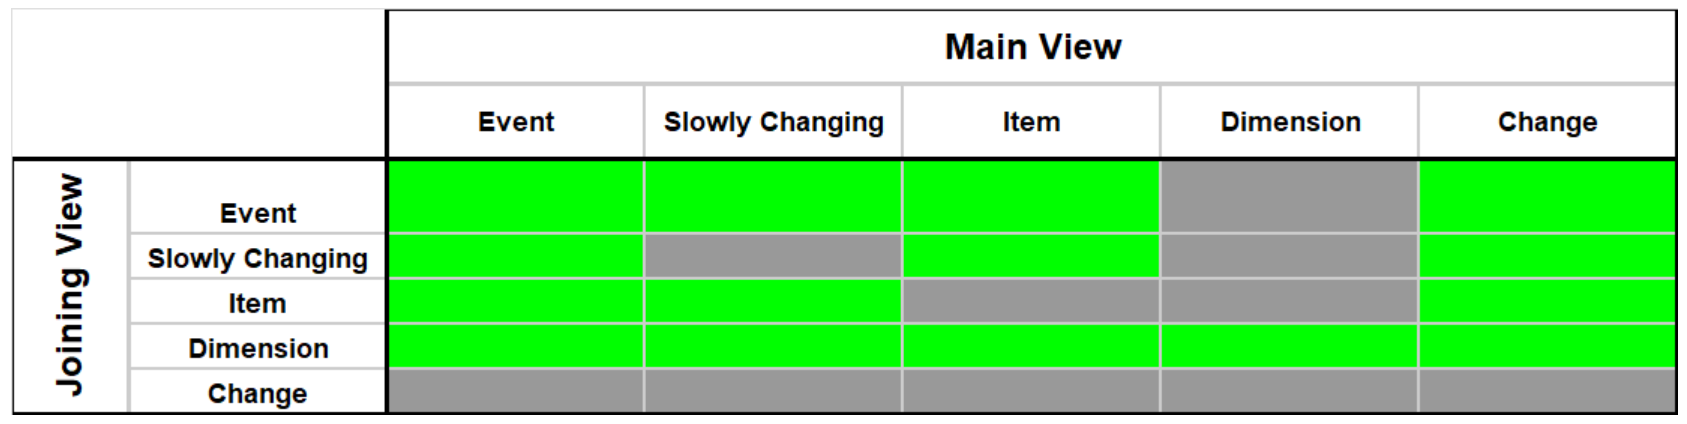

### Concept: Joins can be avoided

With featurebyte, you don't always need to join views to get the features you want.

1. <b>Entity relationships:</b> If a feature is calculated from a single table, and the entity level at which is calculated is the same as, or a parent of the entity level of your feature list, then featurebyte will use entity relationships to automatically apply that feature at the level of your feature list. For example, when state code is an entity, if you declare population of a US state as a feature, and your feature list operates at the customer entity level, featurebyte will know to use the state code of the customer to match the state population to the customer.

2. <b>Features built from features:</b> If a feature is calculated from attributes of more than one table, a user can first declare component features from each table, then declare a new feature that is a transformation of the combination of those component features. For example, you could declare a bank customer's income as a feature from the customer table, the average income per capita by US state as a feature from another table, then build a new feature that is the ratio of the bank customer's income to the state average.

## Aggregate Features

Learning Objectives

In this section you will learn:
* different types of aggregation
* how to use a FeatureGroup
* how to create features by aggregating data
* the purpose and usage of inventory features

### Concept: Aggregate features

Aggregate Features are an important type of feature engineering that involves applying various aggregation functions to a collection of data points grouped by an entity (or a tuple of entities). Supported aggregation functions include the latest, count, sum, average, minimum, maximum, and standard deviation. It is important to consider the temporal aspect when conducting these aggregation operations.

There are three main types of aggregate features, including:
- simple aggregates
- aggregates over a window
- and aggregates "as at" a point-in-time.

If a feature is intended to capture patterns of interaction between two or more entities, these aggregations are grouped by the tuple of the entities. For instance, an aggregate feature can be created to show the amount spent by a customer with a merchant in the recent past.

### Concept: FeatureGroup

A FeatureGroup object is a transient object designed for handling a collection of Feature objects. The object cannot be saved or added to a catalog. Instead, each feature within the group can be saved individually.

### Example: Simple aggregation

Simple Aggregate features refer to features that are generated through aggregation operations without considering any temporal aspect. In other words, these features are created by aggregating values without taking into account the order or sequence in which they occur over time.

To avoid time leakage, simple aggregate is only supported for Item views, when the grouping key is the event key of the Item view. An example of such features is the count of items in Order.

In [15]:
# get the number of items in each invoice
invoice_item_count = grocery_items_view.groupby("GroceryInvoiceGuid").aggregate(
    None, method=fb.AggFunc.COUNT, feature_name="InvoiceItemCount", fill_value=0
)

# get the total discount for each invoice
invoice_total_discount = grocery_items_view.groupby("GroceryInvoiceGuid").aggregate(
    "Discount", method=fb.AggFunc.SUM, feature_name="InvoiceTotalDiscount", fill_value=0
)

# create a FeatureGroup for the invoice features
invoice_aggregation_features = fb.FeatureGroup([invoice_item_count, invoice_total_discount])

display(invoice_aggregation_features.preview(observation_set_invoices))

,POINT_IN_TIME,GROCERYINVOICEGUID,InvoiceItemCount,InvoiceTotalDiscount
0,2022-10-27 11:04:22,6806fcb5-ab2c-439d-a35a-296f2a891a80,8,0.96
1,2022-05-16 10:22:49,ebe9fe2b-2457-470e-b27c-dd07a18186e8,17,6.14
2,2022-08-20 17:31:23,50dd32a2-97f6-4092-8afb-7b7d08430f8b,13,9.35
3,2022-05-12 13:41:39,92d8e1fb-d882-4104-a7e2-794208162c4e,1,1.12
4,2022-11-30 17:55:27,961ea607-9375-4a14-ad70-fc3a6353f963,6,2.58


### Example: Aggregation over a time window

Aggregates over a window refer to features that are generated by aggregating data within a specific time frame. These types of features are commonly used for analyzing event and item data.

To aggregate over a time window, use the aggregate_over function. Window periods are defined using the same format as the Timedelta function in pandas e.g. '7d' is 7 days.

In [16]:
# get the sum of all invoice amounts over the past 90 days for each grocery customer
total_invoice_amount_90d = grocery_invoice_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Amount",
    method=fb.AggFunc.SUM,
    feature_names=["TotalInvoiceAmount_90d"],
    fill_value=0,
    windows=["90d"],
)

display(total_invoice_amount_90d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,TotalInvoiceAmount_90d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,132.77
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,2210.46
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,1238.66
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,13.86
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,213.16


### Concept: Cross-aggregate feature

Cross Aggregate features are a type of Aggregate Feature that involves aggregating data across different categories. This enables the creation of features that capture patterns in an entity across these categories.

For example, the amount spent by a customer on each product category over a specific time period is a Cross Aggregate feature. In this case, the customer is the entity being analyzed and the product category is the categorical variable that the aggregation was done across for each customer. The resulting feature could be used to identify spending patterns or preferences of individual customers across different product categories.

When such a feature is computed for a customer, a dictionary is returned that contains keys representing the product categories purchased by the customer and their corresponding values representing the total amount spent on each category.

Like other types of Aggregate Features, it is important to consider the temporal aspect when conducting aggregation operations. The three main types of Cross Aggregate features include:
- Simple Cross Aggregate
- Cross Aggregate over a window
- Cross Aggregate "as at" a point-in-time.

### Example: Creating a cross-aggregate feature

In [17]:
# get the cross-aggregation of the items purchased over the past 28 days, grouped by customer, subgrouped (i.e. categorized) by product
customer_inventory_28d = grocery_items_view.groupby(
    "GroceryCustomerGuid", category="ProductGroup"
).aggregate_over(
    None, method=fb.AggFunc.COUNT, feature_names=["CustomerInventory_28d"], windows=["28d"]
)

# display a sample of the results
display(customer_inventory_28d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInventory_28d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,"{""Bières et Cidres"":2,""Chips et Tortillas"":2,""..."
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,"{""Adoucissants et Soin du linge"":3,""Aide à la ..."
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,"{""Adoucissants et Soin du linge"":1,""Aide à la ..."
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,"{""Colas, Thés glacés et Sodas"":1,""Eaux"":1}"
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,"{""Colas, Thés glacés et Sodas"":3,""Papeterie"":1..."


In [18]:
# display a single inventory, showing the key + value dictionary structure
print(customer_inventory_28d.preview(observation_set)["CustomerInventory_28d"][0])

{"Bières et Cidres":2,"Chips et Tortillas":2,"Colas, Thés glacés et Sodas":1,"Crèmes et Chantilly":1,"Eaux":1,"Jus Frais":1,"Viennoiseries surgelées":1}


### Example: Aggregation functions on a cross-aggregate feature

Each cross-aggregation feature can be aggregated to a single value, such as entropy, most frequent value, or a lookup against a specific key.

In [19]:
# get the entropy of the inventory
customer_inventory_entropy_28d = customer_inventory_28d["CustomerInventory_28d"].cd.entropy()
customer_inventory_entropy_28d.name = "CustomerProductEntropy_28d"

# get the most frequent item purchased
customer_inventory_most_frequent_4w = customer_inventory_28d[
    "CustomerInventory_28d"
].cd.most_frequent()
customer_inventory_most_frequent_4w.name = "CustomerMostFrequentProduct_4w"

# create a feature group to simplify the displaying of sample feature values
customer_inventory_features_4w = fb.FeatureGroup(
    [customer_inventory_entropy_28d, customer_inventory_most_frequent_4w]
)

# display a sample of the results
display(customer_inventory_features_4w.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerProductEntropy_28d,CustomerMostFrequentProduct_4w
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,1.889159,Bières et Cidres
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,3.328159,"Colas, Thés glacés et Sodas"
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,3.151631,"Colas, Thés glacés et Sodas"
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.693147,"Colas, Thés glacés et Sodas"
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,1.255482,"Colas, Thés glacés et Sodas"


### Example: Aggregate “as at” a point-in-time

Aggregates 'as at' a point-in-time are features that are generated by aggregating data that is active at a particular moment in time. These types of features are only available for slowly changing dimension (SCD) views and the grouping key used for generating these features should not be the natural key of the SCD view.

Note that you can specify an offset, if you want the aggregation to be done on rows active at a specific time before the point-in-time specified by the feature request.

In the example below, you will calculate the average location of all customers in a state. This feature serves two purposes:
1. In the absence of geographic centroid data, it provides a proxy for the location of each state, approximating the location of the largest (by population) city in each state. This will be a more useful signal for each state than just the state name, enhancing the ability of machine learning algorithms to group nearby states together.
2. Later in this tutorial, you will learn how to create a feature that calculates the distance of individual customers from the average location of other customers in the same state. This will be a useful signal for how close a customer lives to the largest city in a state, whether they live in a remote or urban area.

In [20]:
# get the average latitude of the customers in each French state, weighted by customer location
state_mean_latitude = grocery_customer_view.groupby("State").aggregate_asat(
    value_column="Latitude", method=fb.AggFunc.AVG, feature_name="StateMeanLatitude"
)
# get the average latitude of the customers in each French state, weighted by customer location
state_mean_longitude = grocery_customer_view.groupby("State").aggregate_asat(
    value_column="Longitude", method=fb.AggFunc.AVG, feature_name="StateMeanLongitude"
)

# combine the two features into a feature group
state_centroids = fb.FeatureGroup([state_mean_latitude, state_mean_longitude])

# create an observation set listing a subset of the French states
observation_set_state = pd.DataFrame(
    {
        "FRENCHSTATE": [
            "Alsace",
            "Aquitaine",
            "Auvergne",
            "Basse-Normandie",
            "Bourgogne",
            "Bretagne",
            "Centre",
            "Champagne-Ardenne",
            "Corse",
            "Franche-Comté",
            "Haute-Normandie",
            "Île-de-France",
            "Languedoc-Roussillon",
            "Limousin",
            "Lorraine",
            "Midi-Pyrénées",
            "Nord-Pas-de-Calais",
            "Pays de la Loire",
            "Picardie",
            "Poitou-Charentes",
            "Provence-Alpes-Côte d'Azur",
            "Rhône-Alpes",
        ]
    }
)
observation_set_state["POINT_IN_TIME"] = "2023-01-01 00:00:00"

display(state_centroids.preview(observation_set_state))

,FRENCHSTATE,POINT_IN_TIME,StateMeanLatitude,StateMeanLongitude
0,Alsace,2023-01-01,48.177401,7.573264
1,Aquitaine,2023-01-01,44.676056,-0.494788
2,Auvergne,2023-01-01,46.307372,3.361388
3,Basse-Normandie,2023-01-01,49.185354,-0.608146
4,Bourgogne,2023-01-01,47.182230,4.394402
5,Bretagne,2023-01-01,48.354199,-1.871965
6,Centre,2023-01-01,47.662871,1.349651
7,Champagne-Ardenne,2023-01-01,48.815086,4.386780
8,Corse,2023-01-01,42.164113,8.959990
9,Franche-Comté,2023-01-01,47.155083,6.007281


### Concept: ChangeView

A Change View is created from a Slowly Changing Dimension (SCD) table to provide a way to analyze changes that occur in an attribute of the natural key of the table over time.

### Example: Aggregation of changes over a time window

In [21]:
# create events for when the customer changes their address
address_changed_view = grocery_customer_table.get_change_view(track_changes_column="StreetAddress")

# filter out when the past street address is null i.e. we don't want when the very first record was created
address_changed_view = address_changed_view[~address_changed_view.past_StreetAddress.isnull()]

display(address_changed_view.sample())

,GroceryCustomerGuid,new_ValidFrom,past_ValidFrom,new_StreetAddress,past_StreetAddress
0,914fac66-de1f-4e9e-8ee0-1e5205984072,2022-06-26 19:58:31,2019-02-21 19:35:55,26 rue Adolphe Wurtz,15 rue Descartes
1,9a7aae23-2036-4728-809e-cca766af86e0,2022-03-23 06:13:56,2022-02-24 15:06:37,45 Boulevard de Normandie,23 rue des six frères Ruellan
2,0b7196a2-2dab-4218-a234-e193f7bc4470,2022-08-08 14:45:20,2022-08-07 14:28:49,7 rue Jean Vilar,79 Place Napoléon
3,da9493e7-46b5-4e97-9f4c-497048901a0d,2022-01-26 18:19:51,2019-01-03 11:10:53,50 rue de Raymond Poincaré,47 rue de la République
4,11465751-0f71-413d-b8c9-90b5a8f26c5f,2022-10-16 20:52:46,2019-01-13 20:48:29,23 rue du Paillle en queue,80 boulevard Bryas
5,dd1dcef9-26b3-4de6-95b0-36410c1ecf98,2022-05-10 10:16:54,2019-01-25 13:19:09,25 quai Saint-Nicolas,19 rue La Boétie
6,20f61507-e7d7-450d-b44f-665d1dfd889f,2022-07-20 17:32:44,2019-01-03 13:26:25,95 rue Petite Fusterie,50 rue de Penthièvre
7,79b85aee-d548-4e6d-89b0-6969fcce5feb,2022-12-12 15:33:10,2019-01-07 00:35:03,99 rue des Nations Unies,42 rue Jean Vilar
8,25ce88b5-e418-48a7-8915-87dde8c4a777,2022-03-22 14:50:03,2020-05-13 07:59:20,42 rue Bonneterie,94 rue de Penthièvre
9,e2f1aa47-98fc-43dd-811d-5dd7df0316dc,2022-03-20 18:35:46,2019-01-06 15:18:27,90 avenue Jules Ferry,7 rue Jean Vilar


In [22]:
# create a feature that is the count of address changes over the past 365 days
customer_address_change_count_365d = address_changed_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["CustomerAddressChangeCount_365d"],
    windows=["365d"],
)

# display a sample of the results
display(customer_address_change_count_365d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerAddressChangeCount_365d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,1
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0


## Create Features From Features

Learning Objectives

In this section you will learn:
* how to create new features from existing features

### Example: Create features from features

In [23]:
# declare a feature that is a cross-aggregation of the items purchased over the past 6 weeks and 90 days, grouped by customer
customer_inventory = grocery_items_view.groupby(
    "GroceryCustomerGuid", category="GroceryProductGuid"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["CustomerInventory_6w", "CustomerInventory_90d"],
    windows=["6w", "90d"],
)

# How consistent is a customer's purchasing behavior over time?
# create a feature that measures the similarity of the past 6 weeks' purchases versus the past 90 days' purchases
customer_inventory_consistency_6w90d = customer_inventory[
    "CustomerInventory_6w"
].cd.cosine_similarity(customer_inventory["CustomerInventory_90d"])
customer_inventory_consistency_6w90d.name = "CustomerInventoryConsistency_6w90d"

display(customer_inventory_consistency_6w90d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInventoryConsistency_6w90d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,0.904865
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.904113
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.920659
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.707107
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0.659287


In [24]:
# create a feature that is the latest invoice amount for each customer
customer_latest_invoice_amount = grocery_invoice_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Amount",
    method=fb.AggFunc.LATEST,
    feature_names=["CustomerLatestInvoiceAmount"],
    windows=["365d"],
)

# create a feature that is the average invoice amount for each customer over the past 90 days
customer_average_invoice_amount_90d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["CustomerAverageInvoiceAmount_90d"],
    windows=["90d"],
)

# create a feature that is the ratio of the latest invoice amount to the average invoice amount over the past 90 days
customer_invoice_amount_ratio_90d = (
    customer_latest_invoice_amount["CustomerLatestInvoiceAmount"]
    / customer_average_invoice_amount_90d["CustomerAverageInvoiceAmount_90d"]
)
customer_invoice_amount_ratio_90d.name = "CustomerInvoiceAmountRatio_90d"

# display a sample of the results
display(customer_invoice_amount_ratio_90d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInvoiceAmountRatio_90d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,1.353468
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.227247
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.171185
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.717893
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0.304935


## Add a Feature to a View

Learning Objectives

In this section you will learn:
* how to store a feature in a column within a view

In [25]:
# add total discount for the invoice as a column to the invoice view
grocery_invoice_view = grocery_invoice_view.add_feature(
    "TotalDiscountAmount", invoice_total_discount, entity_column="GroceryInvoiceGuid"
)

display(grocery_invoice_view.sample())

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,tz_offset,Amount,Gender_Customer,State_Customer,TotalDiscountAmount
0,e9e2d277-eb8c-45d2-a931-38a1266e0adc,d519b6c9-5f34-4b75-95e3-3778e2d63b01,2022-01-09 18:29:07,+01:00,5.28,female,Provence-Alpes-Côte d'Azur,0.10
1,13d6c6d2-0afb-4085-b61a-b5139183a6bf,0b4abd15-e39a-4e05-8864-a468bcb10348,2022-05-02 09:59:37,+02:00,79.68,male,Île-de-France,8.50
2,0609f1e2-3a7c-4925-a0e5-4d527cda7734,cd76d6f8-905e-4c09-b4d7-b6d09fd6aecb,2022-05-25 11:01:55,+02:00,60.00,male,Midi-Pyrénées,18.77
3,dfb95982-3ad7-457c-a040-c2bb0c6498d0,545a411c-7c4c-4394-b288-6ad9bb0dcee2,2022-01-30 16:11:03,+01:00,13.76,female,Centre,1.57
4,bc82cae1-3571-4510-b17c-033fcd623184,abdef773-ab72-43b6-8e77-050804c1c5fc,2022-11-20 11:35:31,+01:00,14.43,female,Île-de-France,2.16
5,2744ae91-618b-4793-b0b7-941ac642d7f7,07a69c6a-4682-426a-abd2-074f62709e43,2023-02-26 02:12:30,+01:00,25.86,female,Provence-Alpes-Côte d'Azur,3.89
6,8a42703e-8939-4570-b753-b7a657ec924b,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,2022-09-09 13:38:03,+02:00,52.51,male,Haute-Normandie,7.89
7,c0b32de3-6f1c-4894-8223-0002fec7f735,10503446-5ce4-4a03-b014-ea92174122a9,2022-12-23 10:45:49,+01:00,3.65,male,Bourgogne,0.00
8,6999af39-c5b5-4554-b9d2-9b7bccdf6ce8,c0c4da4d-08a3-4a03-a1f6-9c015362caf9,2022-05-24 10:12:50,+02:00,53.61,male,Provence-Alpes-Côte d'Azur,20.26
9,7061e11d-cfde-4deb-9d8c-ba08c9b777b2,05b77e7e-0a50-4341-b18c-be77efe3b084,2022-02-02 14:40:59,+01:00,2.00,female,Midi-Pyrénées,0.58


## Feature naming conventions

With feature creation becoming so easy, you may start to run into namespace conflicts. Featurebyte recommend that you use a feature naming convention that uniquely identifies each feature while providing a useful explanation of the nature of the feature.

The feature names that we use in our tutorials are composed from:
1. primary entity
2. data column name or name of calculated value
3. aggregation function (if applicable)
4. window period (if applicable)

For example, the number of invoices per customer over the past 30 days would be named "CustomerInvoiceCount_30d".

## Creative Feature Ideation

Best practice feature engineering is inspired by the data semantics and a diverse set of signals from the feature list.

Learning Objectives

In this section you will learn:
* the range of signal types that features can capture
* how to create features that capture a diverse range of signal types

### Concept: Signal Types

Every feature has a signal type, a categorization label of what that feature represents. Signal types are common practice in marketing, which uses RFM (recency frequency monetary) metrics to understand customer behaviors. But there are many more signal types beyond RFM.

### Example: Create a recency signal feature

A recency signal is a feature related to the timing or attributes of the latest event to occur.

In [26]:
# declare a feature that is the latest invoice timestamp, grouped by customer
customer_latest_invoice_timestamp = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Timestamp",
    method=fb.AggFunc.LATEST,
    feature_names=["CustomerLatestInvoiceTimestamp"],
    windows=["365d"],
)[
    "CustomerLatestInvoiceTimestamp"
]

# declare a feature that is the elapsed time since the last invoice
# note that since this feature is a function of the prediction point in time, it requires special syntax
customer_hours_since_last_invoice = (
    RequestColumn.point_in_time() - customer_latest_invoice_timestamp
).dt.hour
customer_hours_since_last_invoice.name = "CustomerHoursSinceLastInvoice"

# declare a feature that is the latest invoice amount, grouped by customer
customer_latest_invoice_amount = grocery_invoice_view.groupby("GroceryCustomerGuid").aggregate_over(
    "Amount",
    method=fb.AggFunc.LATEST,
    feature_names=["CustomerLatestInvoiceAmount"],
    windows=["365d"],
)

# combine the two features into a feature group
customer_latest_invoice = fb.FeatureGroup(
    [customer_latest_invoice_amount, customer_hours_since_last_invoice]
)

# display a sample of the results
display(customer_latest_invoice.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerLatestInvoiceAmount,CustomerHoursSinceLastInvoice
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,17.97,166.212778
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,11.96,71.653889
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,2.28,19.256111
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1.99,1.338889
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,2.50,65.831944


### Example: Create a frequency signal feature

A frequency signal is a count of events over a time window.

In [27]:
grocery_invoice_view.sample()

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,tz_offset,Amount,Gender_Customer,State_Customer,TotalDiscountAmount
0,e9e2d277-eb8c-45d2-a931-38a1266e0adc,d519b6c9-5f34-4b75-95e3-3778e2d63b01,2022-01-09 18:29:07,+01:00,5.28,female,Provence-Alpes-Côte d'Azur,0.10
1,13d6c6d2-0afb-4085-b61a-b5139183a6bf,0b4abd15-e39a-4e05-8864-a468bcb10348,2022-05-02 09:59:37,+02:00,79.68,male,Île-de-France,8.50
2,0609f1e2-3a7c-4925-a0e5-4d527cda7734,cd76d6f8-905e-4c09-b4d7-b6d09fd6aecb,2022-05-25 11:01:55,+02:00,60.00,male,Midi-Pyrénées,18.77
3,dfb95982-3ad7-457c-a040-c2bb0c6498d0,545a411c-7c4c-4394-b288-6ad9bb0dcee2,2022-01-30 16:11:03,+01:00,13.76,female,Centre,1.57
4,bc82cae1-3571-4510-b17c-033fcd623184,abdef773-ab72-43b6-8e77-050804c1c5fc,2022-11-20 11:35:31,+01:00,14.43,female,Île-de-France,2.16
5,2744ae91-618b-4793-b0b7-941ac642d7f7,07a69c6a-4682-426a-abd2-074f62709e43,2023-02-26 02:12:30,+01:00,25.86,female,Provence-Alpes-Côte d'Azur,3.89
6,8a42703e-8939-4570-b753-b7a657ec924b,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,2022-09-09 13:38:03,+02:00,52.51,male,Haute-Normandie,7.89
7,c0b32de3-6f1c-4894-8223-0002fec7f735,10503446-5ce4-4a03-b014-ea92174122a9,2022-12-23 10:45:49,+01:00,3.65,male,Bourgogne,0.00
8,6999af39-c5b5-4554-b9d2-9b7bccdf6ce8,c0c4da4d-08a3-4a03-a1f6-9c015362caf9,2022-05-24 10:12:50,+02:00,53.61,male,Provence-Alpes-Côte d'Azur,20.26
9,7061e11d-cfde-4deb-9d8c-ba08c9b777b2,05b77e7e-0a50-4341-b18c-be77efe3b084,2022-02-02 14:40:59,+01:00,2.00,female,Midi-Pyrénées,0.58


In [28]:
# declare a feature that is the count of discounts over the past 4 weeks, grouped by customer
filter = grocery_invoice_view.TotalDiscountAmount > 0
customer_discount_count_4w = (
    grocery_invoice_view[filter]
    .groupby("GroceryCustomerGuid")
    .aggregate_over(
        None, method=fb.AggFunc.COUNT, feature_names=["CustomerDiscountCount_4w"], windows=["4w"]
    )
)

# display a sample of the results
display(customer_discount_count_4w.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerDiscountCount_4w
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,3
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,11
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,14
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,2


### Example: Create a monetary signal feature

A monetary signal is derived from a data column containing monetary amounts.

In [29]:
# declare a feature that is the average invoice amount over the past 28 days, grouped by customer
customer_average_invoice_amount_28d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["CustomerAverageInvoiceAmount_28d"],
    windows=["28d"],
)

# display a sample of the results
display(customer_average_invoice_amount_28d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerAverageInvoiceAmount_28d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,14.016667
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,50.613333
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,9.404000
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1.990000
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,4.264000


### Example: Create an attribute signal feature

An attribute signal is derived from a lookup feature.

In [30]:
# add a year of birth column feature
grocery_customer_view["YearOfBirth"] = grocery_customer_view.DateOfBirth.dt.year

# create a feature from the year of birth column
year_of_birth = grocery_customer_view.YearOfBirth.as_feature("CustomerYearOfBirth")

# display a sample of the results
display(year_of_birth.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerYearOfBirth
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,2003
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,1981
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,1951
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1945
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,1954


In [31]:
# calculate the customer's age

date_of_birth = grocery_customer_view.DateOfBirth.as_feature("DateOfBirth")

# customer age requires the point in time of the prediction
# start with the number of years between the current year and the year of birth
customer_age = RequestColumn.point_in_time().dt.year - date_of_birth.dt.year

# adjust when the customer's birthday is later in the year than the prediction point in time
filter = RequestColumn.point_in_time().dt.month < date_of_birth.dt.month
customer_age[filter] = customer_age[filter] - 1

filter = (RequestColumn.point_in_time().dt.month == date_of_birth.dt.month) & (
    RequestColumn.point_in_time().dt.day < date_of_birth.dt.day
)
customer_age[filter] = customer_age[filter] - 1

customer_age.name = "CustomerAge"

# display a sample of the results
display(customer_age.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerAge
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,18
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,41
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,70
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,77
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,68


### Example: Create a similarity signal feature

An similarity signal is derived by comparing one of the following pairs:
* a lookup feature versus a time window aggregate e.g. latest transaction amount / customer transactions amount avg past 7 days
* a dictionary feature versus another dictionary feature using different entity aggregations e.g. cosine similarity of customer basket past 7 days vs. all customer baskets past 7 days

Similarity signals are helpful for treating customers as individuals and identifying unusual customers and events.

In [32]:
# create a feature that is the latest invoice amount, grouped by customer, over the past 28 days
customer_latest_invoice_amount_28d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.LATEST,
    feature_names=["CustomerLatestInvoiceAmount_28d"],
    windows=["28d"],
)

# create a feature that is the maximum invoice amount, grouped by customer, over the past 28 days
customer_max_invoice_amount_28d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Amount", method=fb.AggFunc.MAX, feature_names=["CustomerMaxInvoiceAmount_28d"], windows=["28d"]
)

# create a feature that is the ratio of the latest invoice amount to the maximum invoice amount
customer_latest_invoice_amount_similarity_28d = (
    customer_latest_invoice_amount_28d["CustomerLatestInvoiceAmount_28d"]
    / customer_max_invoice_amount_28d["CustomerMaxInvoiceAmount_28d"]
)
customer_latest_invoice_amount_similarity_28d.name = "CustomerLatestInvoiceAmountSimilarity_28d"

# display a sample of the results
display(customer_latest_invoice_amount_similarity_28d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerLatestInvoiceAmountSimilarity_28d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,1.000000
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.060401
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.027234
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1.000000
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0.242954


In [33]:
# How similar is a customer's purchasing behavior compared to all other customers?

# declare a feature that is a cross-aggregation of the items purchased over the past 28 days, across all customers
all_inventory_28d = grocery_items_view.groupby(by_keys=[], category="ProductGroup").aggregate_over(
    None, method=fb.AggFunc.COUNT, feature_names=["AllInventory_28d"], windows=["28d"]
)

# create a feature that measures the similarity of the past 28 days' purchases versus all customers' purchases
customer_inventory_all_similarity_28d = customer_inventory_28d[
    "CustomerInventory_28d"
].cd.cosine_similarity(all_inventory_28d["AllInventory_28d"])
customer_inventory_all_similarity_28d.name = "CustomerInventoryAllSimilarity_28d"

# create a multi-row preview of the feature values
display(customer_inventory_all_similarity_28d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInventoryAllSimilarity_28d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,0.409034
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.696444
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.784093
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.406129
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0.421744


### Example: Create a stability signal feature

An stability signal is derived by comparing a dictionary feature versus another dictionary feature using a different time window, for the same entity e.g. cosine similarity of customer basket past 7 days vs. customer baskets past 28 days

Stability signals are helpful for discovering changes in behaviors over time.

In [34]:
# How similar is a customer's purchasing behavior over the past 7 days versus the past 28 days, weighted by expenditure?

# declare a feature that is an inventory of the items purchased over the past 7 and 28 days, grouped by customer
customer_spending_7d_28d = grocery_items_view.groupby(
    "GroceryCustomerGuid", category="GroceryProductGuid"
).aggregate_over(
    "TotalCost",
    method=fb.AggFunc.SUM,
    feature_names=["CustomerSpending_7d", "CustomerSpending_28d"],
    windows=["7d", "28d"],
)

# create a feature that measures the similarity of the past 7 days' purchases versus the past 28 days' purchases
customer_spending_stability_7d_28d = customer_spending_7d_28d[
    "CustomerSpending_7d"
].cd.cosine_similarity(customer_spending_7d_28d["CustomerSpending_28d"])
customer_spending_stability_7d_28d.name = "CustomerSpendingStability_7d28d"

# create a multi-row preview of the feature values
display(customer_spending_stability_7d_28d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerSpendingStability_7d28d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,0.939412
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.812175
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.598625
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,1.000000
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,0.308193


### Example: Create a timing signal feature

A timing signal is derived by comparing multiple event timestamps e.g. entropy of day of week of customer orders

Timing signals are helpful for understanding the regularity and clumpiness (e.g. binge TV watching) of events.

In [35]:
# add a column to the invoice view that is the day of week of the timestamp
grocery_invoice_view["DayOfWeek"] = grocery_invoice_view.Timestamp.dt.day_of_week

# create a feature that is the count of items purchased on each day of the week, grouped by customer, over the past 70 days
customer_day_of_week_inventory_70d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid", category="DayOfWeek"
).aggregate_over(
    None, method=fb.AggFunc.COUNT, feature_names=["CustomerDayOfWeekInventory_70d"], windows=["70d"]
)

# create a feature that is the entropy of the day of week inventory
customer_day_of_week_inventory_entropy_70d = customer_day_of_week_inventory_70d[
    "CustomerDayOfWeekInventory_70d"
].cd.entropy()
customer_day_of_week_inventory_entropy_70d.name = "CustomerDayOfWeekInventoryEntropy_70d"

# display a sample of the results
display(customer_day_of_week_inventory_entropy_70d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerDayOfWeekInventoryEntropy_70d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,1.494175
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,1.808661
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,1.930501
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.693147
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,1.897368


In [36]:
# calculate the inter-event times for each grocery invoice, grouped by customer
ts_col = grocery_invoice_view[grocery_invoice_view.timestamp_column]
grocery_invoice_view["InterEventTime"] = (ts_col - ts_col.lag("GroceryCustomerGuid")).dt.day

display(
    grocery_invoice_view.preview()[
        ["GroceryInvoiceGuid", "GroceryCustomerGuid", "Timestamp", "InterEventTime"]
    ]
)

,GroceryInvoiceGuid,GroceryCustomerGuid,Timestamp,InterEventTime
0,ceb4d897-17b0-4713-a54c-427d258a6b10,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-02-06 14:42:24,NaN
1,37314d62-c29e-4f62-b5f5-b40f8ee50cb9,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-02-18 19:06:59,12.183738
2,898029e5-6cbd-40e6-8047-01e3f1cce512,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-02-24 16:04:00,5.872928
3,30453432-bd46-4246-9788-951e9ffb1a43,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-05-04 13:24:30,68.889236
4,e4c6867a-6b8d-47c0-b6df-e5878c846add,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-05-12 12:51:12,7.976875
5,6a7ad2f1-6d6d-4a30-97eb-26869fa4f5ce,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-07-23 14:54:29,72.085613
6,2c95a53b-58e2-4a5c-a880-410e32156816,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-08-04 11:48:09,11.870602
7,d9878e96-4f4e-4c36-8980-69de31dd91bc,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-08-18 13:43:43,14.080255
8,c5421411-8e78-455e-9b2e-1310fa3a6250,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-09-25 20:35:43,38.286111
9,d8d50443-cc1b-4363-abe0-130a61291a25,0041bdff-4917-42d5-bd6d-5a555ac616c5,2022-11-16 14:37:03,51.750926


In [37]:
# create a feature that is the standard deviation of the inter-event times, grouped by customer, over the past 70 days
customer_inter_event_time_stdev_70d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "InterEventTime",
    method=fb.AggFunc.STD,
    feature_names=["CustomerInterEventTime_stdev_70d"],
    windows=["70d"],
)

# create a feature that is the average of the inter-event times, grouped by customer, over the past 70 days
customer_inter_event_time_avg_70d = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "InterEventTime",
    method=fb.AggFunc.AVG,
    feature_names=["CustomerInterEventTime_avg_70d"],
    windows=["70d"],
)

# calculate the coefficient of variation of the inter-event times
customer_inter_event_time_clumpiness_70d = (
    customer_inter_event_time_stdev_70d["CustomerInterEventTime_stdev_70d"]
    / customer_inter_event_time_avg_70d["CustomerInterEventTime_avg_70d"]
)
customer_inter_event_time_clumpiness_70d.name = "CustomerInterEventTimeClumpiness_70d"

# display a sample of the results
display(customer_inter_event_time_clumpiness_70d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInterEventTimeClumpiness_70d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,0.471970
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,0.759424
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,0.962068
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.572736
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,1.289697


### Example: Create a diversity signal feature

A diversity signal is derived by calculating the variability of a column e.g. standard deviation of invoice amounts, or entropy of product purchases

Diversity signals are helpful for understanding the consistency of attributes.

In [38]:
# create a feature that is the standard deviation of the invoice amounts over the past 8 weeks, grouped by customer
customer_invoice_amount_stdev_8w = grocery_invoice_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "Amount", method=fb.AggFunc.STD, feature_names=["CustomerInvoiceAmountStdev_8w"], windows=["8w"]
)

# display a sample of the results
display(customer_invoice_amount_stdev_8w.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerInvoiceAmountStdev_8w
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,3.935899
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,44.983417
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,24.866058
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,0.495000
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,5.351022


In [39]:
# create a feature that is the entropy of the product groups of items over the past 12 weeks, grouped by customer
customer_product_group_inventory_entropy_12w = grocery_items_view.groupby(
    "GroceryCustomerGuid", category="ProductGroup"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["CustomerProductGroupInventoryEntropy_12w"],
    windows=["12w"],
)

# display a sample of the results
display(customer_product_group_inventory_entropy_12w.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerProductGroupInventoryEntropy_12w
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,"{""Biscuits"":1,""Bières et Cidres"":6,""Chips et T..."
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,"{""Adoucissants et Soin du linge"":12,""Aide à la..."
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,"{""Adoucissants et Soin du linge"":3,""Aide à la ..."
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,"{""Colas, Thés glacés et Sodas"":3,""Eaux"":1,""Gla..."
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,"{""Aide à la Pâtisserie"":3,""Beurre"":2,""Biscuits..."


### Example: Create a location signal feature

Location signals are derived from locations, and include distances between locations.

In [40]:
# define helper functions that approximate the haversine distance between two points on the earth's surface
import math


def approx_cos_degrees(x):
    return approx_cos(x / 180.0 * math.pi)


def approx_cos(x):
    # Taylor series
    return 1.0 - x * x / 2 + x.pow(4) / 24 - x.pow(6) / 720 + x.pow(8) / 40320


def approx_sin_degrees(x):
    return approx_sin(x / 180.0 * math.pi)


def approx_sin(x):
    # Taylor series
    return x - x.pow(3) / 6 + x.pow(5) / 120 - x.pow(7) / 5040 + x.pow(9) / 362880


def ApproxAtan2(y, x):
    PI = math.pi
    PI_2 = math.pi / 2.0
    if x != 0.0:
        if x >= 0.0:
            abs_x = x
        else:
            abs_x = -x
        if y >= 0.0:
            abs_y = y
        else:
            abs_y = -y
        if abs_x > abs_y:
            z = y / x
            if x > 0.0:
                # atan2(y,x) = atan(y/x) if x > 0
                return ApproxAtan(z)
            elif y >= 0.0:
                # atan2(y,x) = atan(y/x) + PI if x < 0, y >= 0
                return ApproxAtan(z) + PI
            else:
                # atan2(y,x) = atan(y/x) - PI if x < 0, y < 0
                return ApproxAtan(z) - PI
        else:  # Use property atan(y/x) = PI/2 - atan(x/y) if |y/x| > 1.
            z = x / y
            if y > 0.0:
                # atan2(y,x) = PI/2 - atan(x/y) if |y/x| > 1, y > 0
                return -ApproxAtan(z) + PI_2
            else:
                # atan2(y,x) = -PI/2 - atan(x/y) if |y/x| > 1, y < 0
                return -ApproxAtan(z) - PI_2
    else:
        if y > 0.0:  # x = 0, y > 0
            return PI_2
        elif y < 0.0:  # x = 0, y < 0
            return -PI_2
    return 0.0  # x,y = 0. Could return NaN instead.


def approx_atan_V1(x):
    # source: https://www-labs.iro.umontreal.ca/~mignotte/IFT2425/Documents/EfficientApproximationArctgFunction.pdf
    if x >= 0.0:
        abs_x = x
    else:
        abs_x = -x
    sign_x = 1 if x >= 0 else -1
    factor = math.pi / 4 * x - x * (abs_x - 1) * (0.2447 + 0.0663 * abs_x)
    return sign_x * factor


def approx_atan_V2(z):
    # source: https://www.dsprelated.com/showarticle/1052.php
    z2 = z * z
    return 0.9724 * z - 0.1919 * z2 * z


def ApproxAtan(z):
    return (approx_atan_V1(z) + approx_atan_V2(z)) / 2.0


def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km

    angle_lat = lat2 - lat1
    angle_lon = lon2 - lon1

    temp1 = approx_sin_degrees(angle_lat / 2)
    temp2 = approx_sin_degrees(angle_lon / 2)

    a = temp1 * temp1 + approx_cos_degrees(lat1) * approx_cos_degrees(lat2) * temp2 * temp2

    c = 2 * ApproxAtan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d

In [41]:
# create features for the latitude and longitude of the customer address
customer_latitude = grocery_customer_view["Latitude"].as_feature("CustomerLatitude")
customer_longitude = grocery_customer_view["Longitude"].as_feature("CustomerLongitude")

# create features for the latitude and longitude of the state centroid address
state_latitude = state_centroids["StateMeanLatitude"]
state_longitude = state_centroids["StateMeanLongitude"]

# create a feature that is the distance between the customer address and the state centroid
customer_state_distance = haversine_distance(
    customer_latitude, customer_longitude, state_latitude, state_longitude
)
customer_state_distance.name = "CustomerStateDistance"

# display a sample of the results
display(customer_state_distance.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerStateDistance
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,11.479681
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,12.481763
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,43.534488
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,118.314223
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,90.410719


### Example: Create a stats signal feature

A stats signal is derived from a calculated feature that is not a recency, frequency, monetary, attribute, similarity, stability, timing, or diversity signal.

In [42]:
# add a column to the items view that is 100 if the item is discounted, and zero otherwise
grocery_items_view["IsDiscounted"] = 0
grocery_items_view.IsDiscounted[grocery_items_view["Discount"] > 0] = 100

# create a feature that is the average of IsDiscounted over the past 21 days, grouped by customer
customer_discounted_item_pct_21d = grocery_items_view.groupby("GroceryCustomerGuid").aggregate_over(
    "IsDiscounted",
    method=fb.AggFunc.AVG,
    feature_names=["CustomerDiscountedItemPct_21d"],
    windows=["21d"],
)

# display a sample of the results
display(customer_discounted_item_pct_21d.preview(observation_set))

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerDiscountedItemPct_21d
0,2022-10-03 10:23:18,edd7c932-6a3e-482d-8e36-1402c2d3c3ff,57.142857
1,2022-11-17 19:23:53,d7316f3d-6ea9-49b6-97f0-3d20ea9d1331,33.663366
2,2022-06-23 16:26:43,197d9b45-2cad-4f77-842e-4df23f7e52d6,33.333333
3,2022-08-01 21:03:58,e5644562-22c9-4aa3-a332-c93cce923596,100.000000
4,2022-06-23 16:32:00,575ceb64-e6ef-446d-9a38-929e35e4cbef,37.500000


## Coherent Feature Lists

Learning Objectives

In this section you will learn:
* how to create a feature list
* the relationship between entities
* the relationship between features and entities
* what is main entity of a feature or feature list
* how a main entity must be consistent with the unit of analysis for a use case

### Example: Create a feature list

In [43]:
# create a feature list from every feature declared in this tutorial
deep_dive_feature_list_not_coherent = fb.FeatureList(
    [
        invoice_aggregation_features,
        total_invoice_amount_90d,
        customer_inventory_28d,
        customer_inventory_features_4w,
        state_centroids,
        customer_address_change_count_365d,
        customer_inventory_consistency_6w90d,
        customer_latest_invoice_amount_28d,
        customer_hours_since_last_invoice,
        customer_max_invoice_amount_28d,
        customer_discount_count_4w,
        customer_average_invoice_amount_28d,
        customer_average_invoice_amount_90d,
        customer_age,
        customer_latest_invoice_amount_similarity_28d,
        customer_inventory_all_similarity_28d,
        customer_spending_stability_7d_28d,
        customer_day_of_week_inventory_entropy_70d,
        customer_inter_event_time_clumpiness_70d,
        customer_invoice_amount_stdev_8w,
        customer_product_group_inventory_entropy_12w,
        customer_state_distance,
        customer_discounted_item_pct_21d,
    ],
    name="deep_dive_grocery_features_not_coherent",
)

In [44]:
# save the feature list to the catalog
deep_dive_feature_list_not_coherent.save()

Saving Feature(s) |████████████████████████████████████████| 26/26 [100%] in 42.
Loading Feature(s) |████████████████████████████████████████| 26/26 [100%] in 6.


### Concept: Parent-Child Entity relationships

A Parent-Child Relationship is a hierarchical connection that links one entity (the child) to another (the parent). Each child entity key value can have only one parent entity key value, but a parent entity key value can have multiple child entity key values.

Examples of parent-child relationships include:

* Hierarchical organization chart: A company's employees are arranged in a hierarchy, with each employee having a manager. The employee entity represents the child, and the manager entity represents the parent.
* Product catalog: In an e-commerce system, a product catalog may be categorized into subcategories and categories. Each category or subcategory represents a child of its parent category.
* Geographical hierarchy: In a geographical data model, cities are arranged in states, which are arranged in countries. Each city is the child of its parent state, and each state is the child of its parent country.
* Credit Card hierarchy: A credit card transaction is the child of a card and a merchant. A card is a child of a customer. A customer is a child of a customer city. And a merchant is a child of a merchant city.

In FeatureByte, the parent-child relationship is automatically established when the primary key (or natural key in the context of a SCD table) identifies one entity. This entity is the child entity. Other entities that are referenced in the table are identified as parent entities.

### Example: Display entity relationships

In [45]:
# show the entity relationships
catalog.list_relationships()

,id,relationship_type,entity,related_entity,relation_table,relation_table_type,enabled,created_at,updated_at
0,646343e51640038c49aaf1c7,child_parent,groceryinvoice,grocerycustomer,GROCERYINVOICE,event_table,True,2023-05-16 08:50:45.561,None
1,646343e51640038c49aaf1c0,child_parent,grocerycustomer,frenchstate,GROCERYCUSTOMER,scd_table,True,2023-05-16 08:50:45.396,None


### Example: Find the entities used by a feature list

In [46]:
# show the feature list in the catalog

# get all feature lists
all_feature_lists = catalog.list_feature_lists()

# display only the matching feature list
display(all_feature_lists[all_feature_lists.name == deep_dive_feature_list_not_coherent.name])

,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,6463448a5ddec2e093fe87a1,deep_dive_grocery_features_not_coherent,26,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS...","[grocerycustomer, groceryinvoice, frenchstate]",2023-05-16 08:54:18.940


### Concept: Primary entity for Feature List and Use Case

<b>Feature List primary entity:</b> The primary entity of a feature list determines the entities that can be used to serve the feature list, which typically corresponds to the primary entity of the Use Case that the feature list was created for.

If the features within the list pertain to different primary entities, the primary entity of the feature list is selected based on the entities relationships, with the lowest level entity in the hierarchy chosen as the primary entity. In cases where there are no relationships between entities, the primary entity may become a tuple comprising those entities.

To illustrate, consider a feature list comprising features related to card, customer, and customer city. In this case, the primary entity is the card entity since it is a child of both the customer and customer city entities. However, if the feature list also contains features for merchant and merchant city, the primary entity is a tuple of card and merchant.

<b>Use Case primary entity:</b> In a Use Case, the Primary Entity is the object or concept that defines its problem statement. Usually, this entity is singular, but in cases such as recommendation engines, it can be a tuple of entities such as (Customer, Product).

In [47]:
# get primary entity of deep_dive_grocery_features_not_coherent
print("primary entity is")
deep_dive_feature_list_not_coherent.primary_entity

primary entity is


 {
   'name': 'groceryinvoice',
   'created_at': '2023-05-16T08:50:45.105000',
   'updated_at': '2023-05-16T08:50:45.638000',
   'serving_names': [
     'GROCERYINVOICEGUID'
   ],
   'catalog_name': 'deep dive feature engineering 20230516:1650'
 }]

### Example: Child entities cannot be materialized

Note that the feature list has features using 3 entities: grocerycustomer, groceryinvoice, and frenchstate.

Grocery invoice is a child of grocery customer, and grocery customer is a child of french state. Therefore the feature list's primary entity is grocery invoice. This feature list cannot be used for use cases where the unit of the problem statement is customer e.g. it cannot be used for customer churn or predicting customer spend.

If the use case is at customer level, an observation set containing customer IDs and points in time is unable to materialize a feature list containing child entities, such as invoice.

In [48]:
# get historical values of the features in the feature list
# this is expected to fail
try:
    historical_features = deep_dive_feature_list_not_coherent.compute_historical_features(
        observation_set
    )
except Exception as ex1:
    print("The feature list cannot be materialized")
    print(ex1)

Retrieving Historical Feature(s) |⚠︎                                       | (!) 
The feature list cannot be materialized
Required entities are not provided in the request: frenchstate (serving name: "FRENCHSTATE"), groceryinvoice (serving name: "GROCERYINVOICEGUID")
If the error is related to connection broken, try to use a smaller `max_batch_size` parameter (current value: 5000).


### Example: Finding and removing features that use a child entity


If the use case is at customer level, we need to remove the features that use entities that are children of the customer entity i.e. remove the features that use the groceryinvoice entity.

In [49]:
# display the features in the deep_dive_feature_list
deep_dive_features = deep_dive_feature_list_not_coherent.list_features()
display(deep_dive_features)

,id,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,646344885ddec2e093fe879f,CustomerDiscountedItemPct_21d,V230516,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-16 08:54:12.684
1,6463447a5ddec2e093fe879c,CustomerStateDistance,V230516,FLOAT,DRAFT,False,[GROCERYCUSTOMER],[GROCERYCUSTOMER],"[grocerycustomer, frenchstate]",[grocerycustomer],2023-05-16 08:54:05.320
2,646344625ddec2e093fe86de,CustomerProductGroupInventoryEntropy_12w,V230516,OBJECT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS, GROCERYPRODUCT]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:58.647
3,646344605ddec2e093fe86dc,CustomerInvoiceAmountStdev_8w,V230516,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:57.745
4,6463445d5ddec2e093fe86d9,CustomerInterEventTimeClumpiness_70d,V230516,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:56.232
5,646344565ddec2e093fe86d2,CustomerDayOfWeekInventoryEntropy_70d,V230516,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:54.313
6,646344525ddec2e093fe86cd,CustomerSpendingStability_7d28d,V230516,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:52.737
7,6463444d5ddec2e093fe86c6,CustomerInventoryAllSimilarity_28d,V230516,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS, GROCERYPRODUCT]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:51.438
8,6463444a5ddec2e093fe86c1,CustomerLatestInvoiceAmountSimilarity_28d,V230516,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:50.201
9,646344465ddec2e093fe86a4,CustomerAge,V230516,INT,DRAFT,False,[GROCERYCUSTOMER],[GROCERYCUSTOMER],[grocerycustomer],[grocerycustomer],2023-05-16 08:53:48.303


In [50]:
# which features use groceryinvoice?
blacklisted = "groceryinvoice"
deep_dive_invoice_features = deep_dive_features.loc[
    [blacklisted in x for x in deep_dive_features.entities.values]
]

# display the features
display(deep_dive_invoice_features)

,id,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
24,6463441c5ddec2e093fe8669,InvoiceTotalDiscount,V230516,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[groceryinvoice],[groceryinvoice],2023-05-16 08:53:32.517
25,6463441b5ddec2e093fe8665,InvoiceItemCount,V230516,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[groceryinvoice],[groceryinvoice],2023-05-16 08:53:31.468


In [51]:
# create a new feature list that excludes the features that use the child entity
deep_dive_feature_list = fb.FeatureList(
    [
        deep_dive_feature_list_not_coherent.feature_objects[x]
        for x in deep_dive_features.name.values
        if x not in deep_dive_invoice_features.name.values
    ],
    name="deep_dive_grocery_features_without_invoice_level_features",
)

# save the feature list to the feature store
deep_dive_feature_list.save()

# get all feature lists
all_feature_lists = catalog.list_feature_lists()

# display only the matching feature list
display(all_feature_lists[all_feature_lists.name == deep_dive_feature_list.name])

Saving Feature(s) |████████████████████████████████████████| 24/24 [100%] in 8.6
Loading Feature(s) |████████████████████████████████████████| 24/24 [100%] in 6.


,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,646344d15ddec2e093fe87bf,deep_dive_grocery_features_without_invoice_lev...,24,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS...","[grocerycustomer, frenchstate]",2023-05-16 08:54:54.774


### Concept: Historical feature table

A HistoricalFeatureTable object represents a table in the feature store containing historical feature values from a historical feature request. The historical feature values can also be obtained as a Pandas DataFrame, but using a HistoricalFeatureTable object has some benefits such as handling large tables, storing the data in the feature store for reuse, and offering full lineage of the training and test data.

In [52]:
# Decide the name of the historical feature table
training_table_name = "deep dive training table"

# Compute the historical feature table
training_table = deep_dive_feature_list.compute_historical_feature_table(
    observation_table, historical_feature_table_name=training_table_name
)

Done! |████████████████████████████████████████| 100% in 2:23.1 (0.01%/s)       


In [53]:
# display the training data
display(training_table.to_pandas())

,POINT_IN_TIME,GROCERYCUSTOMERGUID,CustomerDiscountedItemPct_21d,CustomerStateDistance,CustomerProductGroupInventoryEntropy_12w,CustomerInvoiceAmountStdev_8w,CustomerInterEventTimeClumpiness_70d,CustomerDayOfWeekInventoryEntropy_70d,CustomerSpendingStability_7d28d,CustomerInventoryAllSimilarity_28d,...,CustomerHoursSinceLastInvoice,CustomerLatestInvoiceAmount_28d,CustomerInventoryConsistency_6w90d,CustomerAddressChangeCount_365d,StateMeanLongitude,StateMeanLatitude,CustomerMostFrequentProduct_4w,CustomerProductEntropy_28d,CustomerInventory_28d,TotalInvoiceAmount_90d
0,2022-04-02 19:30:03,aae48cd3-7646-4df6-9700-3ef7f29ec80f,55.555556,41.132607,"{""Adoucissants et Soin du linge"":1,""Boissons é...",12.767799,0.899681,1.418484,0.161832,0.414041,...,104.323333,4.02,0.732114,0,-1.075038,47.401700,Chips et Tortillas,2.447151,"{""Adoucissants et Soin du linge"":1,""Boissons é...",119.18
1,2022-04-03 22:04:01,d36196d6-6761-4c20-a17c-d611171127ea,66.666667,1300.114776,"{""Biscuits"":1,""Chips et Tortillas"":1,""Colas, T...",2.561410,1.006454,1.039721,0.542541,0.533327,...,72.435833,4.48,0.653720,0,-50.017299,19.829759,Laits,2.043192,"{""Biscuits"":1,""Chips et Tortillas"":1,""Fromages...",39.94
2,2022-04-04 19:27:25,cd9d2656-375c-4b43-8f7c-5f89729fd5f4,72.000000,13.108172,"{""Aide à la Pâtisserie"":1,""Animalerie, Soins e...",13.368702,0.757438,1.676988,NaN,0.533234,...,432.951111,38.78,0.815647,0,3.330159,43.404298,Fruits secs,2.968392,"{""Animalerie, Soins et Hygiène"":1,""Bonbons"":1,...",101.26
3,2022-04-06 08:11:45,3dff3cdc-3e64-4b6f-ab62-8165afca8c55,44.444444,8.620143,"{""Adoucissants et Soin du linge"":1,""Animalerie...",17.330878,0.954401,1.778233,0.430855,0.696141,...,61.937222,28.48,0.933728,0,2.237559,48.740582,Pains,3.362678,"{""Animalerie, Soins et Hygiène"":1,""Apéritifs e...",583.79
4,2022-04-06 16:38:07,b8109419-c2a0-4a2b-be49-8cc2fff792d5,56.250000,8.085260,"{""Animalerie, Soins et Hygiène"":2,""Autres"":2,""...",5.796691,0.596381,1.767195,0.607751,0.731148,...,24.383056,10.67,0.608781,0,-0.517205,44.663768,"Colas, Thés glacés et Sodas",2.344618,"{""Biscuits apéritifs"":1,""Bières et Cidres"":2,""...",221.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-12-22 15:21:23,6bb41075-390e-43ba-b416-55d802ede820,60.000000,41.982448,"{""Animalerie, Soins et Hygiène"":1,""Biscuits ap...",5.814690,0.654404,1.771624,0.511962,0.497532,...,23.483056,2.67,0.786166,0,-0.387129,46.072548,Café,1.886697,"{""Café"":2,""Chien"":2,""Chips et Tortillas"":1,""Co...",130.21
196,2022-12-22 16:50:32,5d0e0100-e2ec-40da-91d2-f860ed478bad,66.666667,54.000714,"{""Bières et Cidres"":3,""Cave à Vins"":1,""Fromage...",4.519914,0.496961,1.609438,1.000000,0.192875,...,97.739167,12.12,0.704664,0,5.887195,43.456104,Fromages,1.098612,"{""Fromages"":1,""Punch et Cocktails"":1,""Viennois...",90.67
197,2022-12-25 20:42:16,3019bdbf-667c-4081-acb5-26cd2d559c5e,70.370370,3.953807,"{""Animalerie, Soins et Hygiène"":1,""Autres Prod...",12.059734,1.137695,1.886913,0.633220,0.618101,...,40.478056,5.49,0.832050,0,45.189819,-12.713308,Viande Surgelée,3.056282,"{""Animalerie, Soins et Hygiène"":1,""Autres"":9,""...",948.57
198,2022-12-27 19:49:30,5060f005-4397-458b-b8ed-2cfd5ad437fd,55.555556,45.465850,"{""Autres Produits Laitiers"":2,""Biscuits apérit...",16.099222,0.739131,1.909234,0.758862,0.737458,...,24.009167,4.07,0.911985,0,4.394402,47.182230,Légumes Frais,3.298687,"{""Autres Produits Laitiers"":1,""Biscuits apérit...",369.83


## Next Steps

Now that you've completed the deep dive feature engineering tutorial, you can put your knowledge into practice or learn more:<br>
1. Put your knowledge into practice by creating features in the "credit card dataset feature engineering playground" or "healthcare dataset feature engineering playground" catalogs
2. Learn more about feature governance via the "Quick Start Feature Governance" tutorial
3. Learn about data modeling via the "Deep Dive Data Modeling" tutorial